# MAPseq Data Processing

In this Jupyter notebook, we will guide you through the steps for turning raw sequencing reads into a viral barcode matrix, which you can then analyze yourself or in conjunction with BARseq data, as we will do in this course.

All the code is Python, using standard libraries and idioms. But some of the key functionality is provided by the Pandas library, which itself is built on NumPy. To learn more about them, and the Python language visit: 

- https://www.python.org/
- https://pandas.pydata.org/ 
- https://numpy.org/
# Imports

In [1]:
# Built-in python libraries
import logging
import os
import sys
from configparser import ConfigParser

# Data science libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
from dask.dataframe import from_pandas

# For handling barcode tags or other fields with letters and numbers. 
from natsort import natsorted

# Allowing to run our custom libraries from git area. 
gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)
from mapseq.core import *
from mapseq.barcode import *
from mapseq.utils import *
from mapseq.bowtie import *
from mapseq.stats import *

gitpath=os.path.expanduser("~/git/mapseq-analysis")
sys.path.append(gitpath)
from msanalysis.analysis import * 
print("Done")

Done


# Overview

The overall goal is to take the paired-end RNA sequencing FASTQ data and produce a correct matrix of viral barcodes and their projections to dissected areas. This is implemented as a pipeline of functions, with the first consuming the FASTQs and the others consuming the output of the previous step, until the final step produces the matrices.  

![title](files/mapseq-processing-schema-api.png)

# Configuration, logging, and paths for analysis
We need to provide paths to the two fastq read files (either fastq or fastq.gz), the path to the a standard Python configuration file, and a standard sample information Excel spreadsheet. We also have a convenience method to package up the FASTQ file pairs.  

This is an example sample info spreadsheet. 

![title](files/sampleinfo-xlsx.png)

The Site information column should indicate whether the dissected area is a target or injection, and additionally whether it is a negative (biological control) or control (water). 
Region and Brain should be obvious. Note that the region labels will be used (if available) for the default plots.  

The RT primer barcode table is included in the software, as 

<code>~/git/mapseq-processing/etc/barcodes_v2.txt</code>

By default, functions in the pipeline take their parameters from a single configuration file, included in the distribution <code>~/git/mapseq-processing/etc/mapseq.conf</code>. If you want to perform processing with parameters other than the defaults, then copy the config in the distrubtion, edit it, and use it instead. For some functions, parameters can be overridden in the function call itself.  

Here are a couple example sections of the configuration file. We will revisit it for each function in more detail. 

![title](img/mapseq-config.png)

A configuration file simply has sections, within which there are key-value pairs. These values can be retrieved by the ConfigParser interface.  


In [7]:
#cp = get_default_config()
configfile = os.path.expanduser('~/mapseq/M205/M205.mapseq.conf')
cp = ConfigParser()
cp.read(configfile)
logging.getLogger().setLevel(logging.INFO)
sampleinfo = os.path.expanduser('~/mapseq/M205/M205.sampleinfo.xlsx')
bcfile = os.path.expanduser( cp.get('barcodes','ssifile') )
project_id = cp.get('project','project_id')

infilelist = [
    os.path.expanduser('~/mapseq/M205/fastq/M205_HZ_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/mapseq/M205/fastq/M205_HZ_S1_R2_001.fastq.gz')
          ]
infiles = package_pairs(infilelist)
outdir = os.path.expanduser('~/mapseq/M205')
print(f"For {project_id}:\nconfig={configfile}\nbcfile={bcfile}\ninfiles={infiles}\noutdir={outdir}\nDone")

INFO:root:input pair: r1=/Users/hover/mapseq/M205/fastq/M205_HZ_S1_R1_001.fastq.gz r2=/Users/hover/mapseq/M205/fastq/M205_HZ_S1_R2_001.fastq.gz


For M205:
config=/Users/hover/mapseq/M205/M205.mapseq.conf
bcfile=/Users/hover/git/mapseq-processing/etc/barcode_v2.txt
infiles=[('/Users/hover/mapseq/M205/fastq/M205_HZ_S1_R1_001.fastq.gz', '/Users/hover/mapseq/M205/fastq/M205_HZ_S1_R2_001.fastq.gz')]
outdir=/Users/hover/mapseq/M205
Done


# Load Sample Information

We load the information from the Excel spreadsheet into a Pandas dataframe. What you see should correspond to what was in the Excel file. 
If it does not, check the formatting of the fields in the spreadsheet (leading/trailing spaces, incorrect capitalization, etc.). The loading code expects the column headers to be exactly as shown here, no blank rows, and no extraneous info below the main table.   


In [5]:
sampdf = load_sample_info(sampleinfo, cp=cp)
sampdf

INFO:root:no column matrixcolumn, required. Creating...
INFO:root:loaded DF from Excel /Users/hover/mapseq/M205/M205.sampleinfo.xlsx


,usertube,samplename,si_ratio,min_reads,ourtube,siteinfo,rtprimer,brain,region
0,OB,Olfactory Bulb,1.0,1,1,target-negative,1,YW143,OB
1,ACB,ACB,1.0,1,2,target,2,YW143,ACB
2,AI,AI,1.0,1,3,target,3,YW143,AI
3,CP,CP (dorsal part - can just dissect out the top...,1.0,1,4,target,4,YW143,CP
4,MTN,MTN,1.0,1,5,target,5,YW143,MTN
5,BLAa,BLAa,1.0,1,6,target,6,YW143,BLAa
6,PIR,Piriform Cortex,1.0,1,7,target,7,YW143,PIR
7,VTA,VTA,1.0,1,8,target,8,YW143,VTA
8,TeA,TeA,1.0,1,9,target,9,YW143,TeA
9,ENTl,ENTl,1.0,1,10,target,10,YW143,ENTl


# process_fastq_pairs()

Here is an example of the first few lines of a FASTQ-formatted data file. 

![title](files/fastq-format.png)

Information about each read uses four lines of the file. The first line is the sequence ID, often containing info about the experiment, sequencing hardware, and run-specific metadata.  
The second line is the actual sequence. 
The third line may have optional information. 
The fourth line has encoded quality estimates for each of the bases in line two.  

We are only interested in the sequence line. 

Note that some raw data may come in multiple pairs of files, and is often compressed (with gzip). The program can read multiple pairs as long as they sort properly alphabetically, and it correctly handles compressed or uncompressed files. This function pulls out the sequence lines from the first read FASTQ, and joins them with the corresponding sequence from the seconds read FASTQ.

The function pulls out all the sequence lines, splits the sequence by fields, and generates a read-oriented table in a form that is easy to manipulate. Each row of the dataframe is a single read. 

![title](files/fastq-schema.png)

Run the cell. It will call the function and display the resulting table. For our data this should take about a minute. As it runs, it will display progress messages per 1000000 sequences.    


In [9]:
# handle all the input. usually takes ~2 minutes
# M205.htna25
logging.getLogger().setLevel(logging.DEBUG)
rdf = process_fastq_pairs(infiles, outdir=outdir, cp=cp)
logging.getLogger().setLevel(logging.INFO)
rdf

INFO:root:Handling FASTQ parsing...
INFO:root:chunksize=50000000 lines.
DEBUG:root:read1[0:32] + read2[0:20]
DEBUG:root:matched M205 part of M205_HZ_S1_R1_001.fastq.gz
INFO:root:handling /Users/hover/mapseq/M205/fastq/M205_HZ_S1_R1_001.fastq.gz, /Users/hover/mapseq/M205/fastq/M205_HZ_S1_R2_001.fastq.gz source_label=M205
DEBUG:root:handling gzipped file...
DEBUG:root:handling gzipped file...
DEBUG:root:chunk1=                                             0
0         AAGCGCCTGTTTTTTGTGGGGCTAATTCGGTCGTAC
1         CCCAGCTTCTTTATAAGAATAAACGTATTTTCGTAC
2         TACGTAGTAATGGTGTTTACGTCAAACACCCCGTAC
3         GGAAGCCCTCGGGGGAGGCGTTCGGGTAGCTTGTAC
4         CGTTGGCCGTTTCCGCGTGGTGGGGTTAGTGGCACT
...                                        ...
17028996  GTGGTGAGCATACGTTGGGGGCCGAGCGGGTTGTAC
17028997  CGGTCAGGCATCCACGGCGCTTTAAAATAGTTGTTA
17028998  TGACTCATATCTAAACCAGTCCTTGACGAACGTGCC
17028999  GCGCCCCTCATGGCTTGACGGAGATCTCACTCGTAC
17029000  TTAACCGGCTGACATCGGTTTGTATGTAGCTCGTAC

[17029001 rows x 1 colu

,sequence,source
0,AAGCGCCTGTTTTTTGTGGGGCTAATTCGGTCTGGATGGTCACTTG...,M205
1,CCCAGCTTCTTTATAAGAATAAACGTATTTTCTTTTGGAAGTTACC...,M205
2,TACGTAGTAATGGTGTTTACGTCAAACACCCCTGGCGTGGGGGATC...,M205
3,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGCTTCGGGGGTGCCGTCC...,M205
4,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGTGGTCGAGCTTAGGGCC...,M205
...,...,...
17028996,GTGGTGAGCATACGTTGGGGGCCGAGCGGGTTGACACGAACTGGCC...,M205
17028997,CGGTCAGGCATCCACGGCGCTTTAAAATAGTTTTGGCTTCCTTGCT...,M205
17028998,TGACTCATATCTAAACCAGTCCTTGACGAACGCGCAACCTGTGACG...,M205
17028999,GCGCCCCTCATGGCTTGACGGAGATCTCACTCAGTAGTCAGCTACC...,M205


Note that the number of rows represents the total number of raw reads. At this point we have retained the initial 52nt full read.
Below is additional Pandas code that shows examples of how further information can be extracted at this point. Feel free to edit and re-run. Whatever the last variable or call is will be displayed.   

### aggregate_reads_dd()
Each row represents a read, but many of these rows are identical (or they should be, if the sequencing read depth is sufficient). 
So we aggregate the reads and set a read_count column. This greatly reduces the dataframe size. We are using Dask under the hood to do this, because most real datasets will exceed system memory.  

Dask requires a dataframe in its own format, so we convert it. 

This step also drops reads with only a single copy. If you want to retain all, set min_reads=1. 

In [13]:
adf = aggregate_reads(rdf, outdir=outdir, cp=cp)
adf

INFO:root:aggregate_reads: use_dask=False dask_temp=None min_reads=1
INFO:root:min_reads = 1 skipping initial read count thresholding.
INFO:root:final output DF len=10625711


,sequence,source,read_count
0,AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAAGATCGGAAGAGCG...,M205,125
1,GGGAGGGTAGTCGGAACCGAAGAAGACTCAAATGAGGGGTTGACCA...,M205,27
2,TCAAATAACCCTGAAACAAATGCTTAGGGATTGAGCGTATGCCGCA...,M205,25
3,GAAACCAATCCGCGGCATTTAGTAGCGGTAAAAACGTTATATTTTG...,M205,25
4,GAGCGTCCGGTTAAAGCCGCTGAATTGTTCGCGACCAATCTGACCA...,M205,25
...,...,...,...
10625706,CTCGACAGCGGCGGGGGGGCTGCTTGTGGGTTCCGGGGGGCCTTCC...,M205,1
10625707,CTCGACAGCGGCGGGGGGGCTGCTTGTGGGTTCCGGCCCTGTGACC...,M205,1
10625708,CTCGACAGCGGCGGGGGGGCTGCTTGTGGGTTCCGAGATTTACACC...,M205,1
10625709,CTCGACAGCGGCGGGGGGGCTGCTTGTGGGTTCCCTATTCGCTTCC...,M205,1


Note how the row count has dropped signficantly--from 17M to 4M. 

# split_fields()  and filter_fields()

Now we are going to filter the reads in order to remove rows that have 'N' characters, which are nucleotides the sequencing process was unable to resolve. We will also remove sequences with long runs of the same nucleotide (>7) since we know these result in unreliable sequences. 

We will also now split the overall sequence into MAPseq-specific fields, and drop the full sequence column (since we don't need it anymore) 

This function should only take a few seconds...

In [17]:
sdf = split_fields(adf.copy(), column='sequence', drop=True, cp=cp )
sdf

INFO:root:pulling out all fields defined in config.
INFO:root:dropping sequence column to slim.
INFO:root:df done. len=10625711 returning...


,source,read_count,vbc_read,spikeseq,libtag,umi,ssi
0,M205,125,AGATCGGAAGAGCGGTTCAGCAGGAATGCC,AATGCCGA,GA,AGATCGGAAGAG,CGTCGTGT
1,M205,27,GGGAGGGTAGTCGGAACCGAAGAAGACTCA,GACTCAAA,AA,TGAGGGGTTGAC,CAAGCGAA
2,M205,25,TCAAATAACCCTGAAACAAATGCTTAGGGA,TAGGGATT,TT,GAGCGTATGCCG,CATGACCT
3,M205,25,GAAACCAATCCGCGGCATTTAGTAGCGGTA,GCGGTAAA,AA,AACGTTATATTT,TGATAGTT
4,M205,25,GAGCGTCCGGTTAAAGCCGCTGAATTGTTC,TTGTTCGC,GC,GACCAATCTGAC,CAGCAAGG
...,...,...,...,...,...,...,...
10625706,M205,1,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,TGTGGGTT,TT,CCGGGGGGCCTT,CCTGGTTG
10625707,M205,1,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,TGTGGGTT,TT,CCGGCCCTGTGA,CCTGGTTG
10625708,M205,1,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,TGTGGGTT,TT,CCGAGATTTACA,CCTGGTTG
10625709,M205,1,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,TGTGGGTT,TT,CCCTATTCGCTT,CCTGGTTG


In [18]:
fdf = filter_fields(sdf.copy(), cp=cp)
fdf

INFO:root:Not removing mismatches.


,source,read_count,vbc_read,spikeseq,libtag,umi,ssi
0,M205,125,AGATCGGAAGAGCGGTTCAGCAGGAATGCC,AATGCCGA,GA,AGATCGGAAGAG,CGTCGTGT
1,M205,27,GGGAGGGTAGTCGGAACCGAAGAAGACTCA,GACTCAAA,AA,TGAGGGGTTGAC,CAAGCGAA
2,M205,25,TCAAATAACCCTGAAACAAATGCTTAGGGA,TAGGGATT,TT,GAGCGTATGCCG,CATGACCT
3,M205,25,GAAACCAATCCGCGGCATTTAGTAGCGGTA,GCGGTAAA,AA,AACGTTATATTT,TGATAGTT
4,M205,25,GAGCGTCCGGTTAAAGCCGCTGAATTGTTC,TTGTTCGC,GC,GACCAATCTGAC,CAGCAAGG
...,...,...,...,...,...,...,...
10625706,M205,1,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,TGTGGGTT,TT,CCGGGGGGCCTT,CCTGGTTG
10625707,M205,1,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,TGTGGGTT,TT,CCGGCCCTGTGA,CCTGGTTG
10625708,M205,1,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,TGTGGGTT,TT,CCGAGATTTACA,CCTGGTTG
10625709,M205,1,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,TGTGGGTT,TT,CCCTATTCGCTT,CCTGGTTG


Below is an area to again play with data exploration. 

In [25]:
# Compare libtag diversity after filtering with that above. 
fdf['libtag'].value_counts()

libtag
TT    2574224
TC    1959202
CT    1923405
CC    1296097
AA     534238
GA     462438
AG     454881
GG     414192
TG     247937
CG     185473
AC     106615
GC     102394
GT     100745
TA      91337
CA      86741
AT      85792
Name: count, dtype: int64[pyarrow]

This is a good time to be aware that many of the functions in the pipeline fill in statistics and QC information in a file named <code>stats.\<datestring\>.json</code> where the datestring is the time the Jupyter session was initialized. These stats files are intended to be both human and machine readable, so they can be used to make reports, or plots. 

Here is an example of the contents of the stats file at this point of the processing:

![title](files/stats-fastq.png)

In [19]:
fdf['read_count'].max()
fdf['read_count'].median()
fdf['read_count'].describe()
fdf['vbc_read'].value_counts().describe()

count      721929.0
mean      14.718499
std      125.722768
min             1.0
25%             1.0
50%             1.0
75%             5.0
max         26849.0
Name: count, dtype: double[pyarrow]

# align_collapse()

As the MAPseq virus replicates in the cell, it is prone to a fairly high error rate. If we didn't account for this, we might attribute viral barcodes that came from a single cell to multiple cells. So we are going to find all the sets of viral barcodes (vbc_read) column that are within a Hamming distance of 3 (i.e. all sequences that can be made identical with 3 or less single nucleotide edits). For each of those sets, we will set the vbc_read sequence to the same sequence. This schematic illustrates the process.  

![title](files/align-collapse.png)

Note that the number of rows has not changed, and each row still represents one read. Even after collapse we retain the read_count for the rows, so at any point we can threshold on that value. 

We will perform the search by doing an all x all alignment using bowtie. We parse the bowtie output to create an edge graph. We use Tarjan's algorithm to find all the components for a given graph. Then we collapse the vbc_read sequences to the most common sequence variant in the component.  

This is the most memory and CPU-intensive function in the pipeline, and can take a long time for large datasets. For the workshop the dataset is relatively small, so it should complete in 3-5 minutes. 

In [20]:
cdf = align_collapse_pd(fdf.copy(), 
                       outdir=outdir, 
                       cp=cp)
cdf

INFO:root:set new recursionlimit=40000
INFO:root:Getting unique DF...
INFO:root:Writing uniques as FASTA to /Users/hover/mapseq/M205/vbc_read.unique.fasta
INFO:root:Running bowtie2 on /Users/hover/mapseq/M205/vbc_read.unique.fasta file to /Users/hover/mapseq/M205/unique_sequences.bt2.sam
INFO:root:Bowtie done. Produced output /Users/hover/mapseq/M205/unique_sequences.bt2.sam. Checking DF.
INFO:root:Creating btdf dataframe from /Users/hover/mapseq/M205/unique_sequences.bt2.sam max_mismatch=3
INFO:root:Processed 1000000 entries. Last line+no=1721931
INFO:root:Calculating Hamming components...
INFO:root:Collapsing 76921 components...
INFO:root:building seqmapdict 721929 unique seqs, 73076 components, for 10625711 raw sequences. 
INFO:root:seqmapdict built. Applying.
INFO:root:applying seqmapdict...
INFO:root:New collapsed df = 
         source  read_count                        vbc_read  spikeseq libtag  \
0          M205         125  AGATCGGAAGAGCGGTTCAGCAGGAATGCC  AATGCCGA     GA   
1  

,source,read_count,spikeseq,libtag,umi,ssi,vbc_read
0,M205,125,AATGCCGA,GA,AGATCGGAAGAG,CGTCGTGT,GATCGGAAGAGCGGTTCAGCAGGAATGCCG
1,M205,27,GACTCAAA,AA,TGAGGGGTTGAC,CAAGCGAA,GGGAGGGTAGTCGGAACCGAAGAAGACTCA
2,M205,25,TAGGGATT,TT,GAGCGTATGCCG,CATGACCT,CAAATAACCCTGAAACAAATGCTTAGGGAT
3,M205,25,GCGGTAAA,AA,AACGTTATATTT,TGATAGTT,GAAACCAATCCGCGGCATTTAGTAGCGGTA
4,M205,25,TTGTTCGC,GC,GACCAATCTGAC,CAGCAAGG,GAGCGTCCGGTTAAAGCCGCTGAATTGTTC
...,...,...,...,...,...,...,...
10625706,M205,1,TGTGGGTT,TT,CCGGGGGGCCTT,CCTGGTTG,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG
10625707,M205,1,TGTGGGTT,TT,CCGGCCCTGTGA,CCTGGTTG,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG
10625708,M205,1,TGTGGGTT,TT,CCGAGATTTACA,CCTGGTTG,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG
10625709,M205,1,TGTGGGTT,TT,CCCTATTCGCTT,CCTGGTTG,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG


Again, note that the total number of rows is the same. The vbc_read column now contains the "fixed" sequence. 

We can look at the new entry in the stats file for deeper insight. 

![title](files/stats-collapse.png)

We can see that of ~16M VBC sequences, there were only 715k unique vbc_read sequences. Component numbers can also be informative. n_components is the total number of Hamming sets. n_multi_components is the number of those sets that had more than one distinct sequence in them (meaning there was a mutation). So the large majority of Hamming components consist of sequence variants.  

The cell below is for exploration...

In [27]:
# Compare diversity of read values after collapse to the one above before colllapse
# Why did the mean go down?
cdf['vbc_read'].value_counts().describe()

count    521799.000000
mean         20.363609
std         152.143889
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       27486.000000
Name: count, dtype: float64

# process_make_readtable_pd()

Now that we have a collapsed table of reads, we can fill in, for convenience, the information determined by the SSI barcode, identify the libtags, and identify spike-in sequences. As part of that process, we will also identify reads which have errors such that that information cannot be filled in, and remove them. 

This is where we calculate an estimate of the template switching rate. The evidence for this is when we see an L1 libtag in a read with a valid target SSI. Information needed to calculate the rate is in the stats entry for the readtable function.

As part of this we will automatically generate read count frequency plots so that we can confirm that our read count threshold (2 by default) are reasonable. Frequency plots are done separately for target and injection, since those are sequenced in different pools. In the raw plot, we include an **estimated_threshold**. This is a value calculated as the threshold that retains 90% of the total data.  

This step should only take a few seconds...


In [28]:
rtdf = process_make_readtable_pd( cdf.copy(),
                                   sampdf,
                                   bcfile=bcfile, 
                                   outdir=outdir, 
                                   cp=cp)
rtdf

INFO:root:inbound df len=10625711 columns=['source', 'read_count', 'spikeseq', 'libtag', 'umi', 'ssi', 'vbc_read']
INFO:root:filling in rtprimer number by SSI sequence...
INFO:root:filling in label by rtprimer...
INFO:root:Wrote bad_ssi DF len=2108949 to /Users/hover/mapseq/M205/bad_ssi.tsv
INFO:root:identifying L2 (reals) by libtag...
INFO:root:identifying L1s by libtag...
INFO:root:Identifying spikeins by spikeseq=CGTCAGTC
INFO:root:Wrote bad_type DF len=445741 to /Users/hover/mapseq/M205/bad_type.tsv
INFO:root:Writing template switch DF len=1373568 Writing to /Users/hover/mapseq/M205/template_switch.tsv
INFO:root:old dataframe dtypes=
source                 object
read_count              int64
umi           string[pyarrow]
vbc_read               object
rtprimer             category
label                category
site                   object
type                   object
brain                  object
region                 object
ourtube                object
dtype: object
INFO:root:

,source,read_count,umi,vbc_read,rtprimer,label,site,type,brain,region,ourtube
0,M205,11,CCCTTATCAAGG,CAATATTAGTTCTCACTTGGGTTGATCCGG,16,BC16,target,real,YW144,CP,16
1,M205,11,GACAATCTAGCC,CTGACCGGCGCCTGTACGTGGGATTTATCC,14,BC14,target,real,YW144,ACB,14
2,M205,11,CGCAGTAACAGT,TATGCGACCTCCAGCCGATCGTCATGTGTT,16,BC16,target,real,YW144,CP,16
3,M205,10,CGTAGAGGGAGA,AAATCTAGCGTTTAATAAGATTTCGAGGCT,14,BC14,target,real,YW144,ACB,14
4,M205,10,AAGTTCCCACGG,CAGATGCGTATCGAAAATTGCCTCGTGGTT,4,BC4,target,real,YW143,CP,4
...,...,...,...,...,...,...,...,...,...,...,...
6697448,M205,1,CCGGGGTACTGA,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,16,BC16,target,real,YW144,CP,16
6697449,M205,1,CCGGGGGGCCTT,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,16,BC16,target,real,YW144,CP,16
6697450,M205,1,CCGGCCCTGTGA,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,16,BC16,target,real,YW144,CP,16
6697451,M205,1,CCGAGATTTACA,CTCGACAGCGGCGGGGGGGCTGCTTGTGGG,16,BC16,target,real,YW144,CP,16


Note that data from the sample information spreadsheet has now been integrated into the read table. The type value has been set from the libtag and the spike sequence. The label, rtprimer number, and brain id has been set from matching the SSI sequence. 

Since this is a small dataset, and read depth is thus low, a read threshold of 2 is reasonable. 

Below is a cell to play with...

In [30]:
# Let's get an idea of the number of reals and spikes by target area
rtdf.groupby(['label','type'], observed=True ).agg( { 'umi':'nunique', 'read_count':'sum'}).reset_index()


,label,type,umi,read_count
0,BC1,real,1841,2731
1,BC1,spike,2640,4294
2,BC10,real,5315,8421
3,BC10,spike,1746,2749
4,BC11,real,1954,2965
5,BC11,spike,1765,2715
6,BC12,real,5211,8357
7,BC12,spike,555,894
8,BC13,real,388,481
9,BC13,spike,2328,3756


# process_make_vbctable_pd()

So far the data tables have been read-oriented (each row is a read). Now we are ready to move toward a viral barcode-oriented format, with each row representing a viral barcode, which represents a single neuron. And this is the step where we will threshold on the read_count value we checked above. 

After data thresholding and cleaning, and dropping some redundant columns, this function aggregates on the viral barcode and sums the UMI count. This function takes less than a minute.  


In [31]:
vdf = process_make_vbctable_pd(rtdf.copy(),
                               outdir=outdir,
                               cp=cp)
vdf

INFO:root:DF before removing nomatch: 6697453
INFO:root:DF after removing nomatch/NaN: 6697453
INFO:root:thresholding by read count. inj=2 target=2 len=6697453
INFO:root:DF after threshold inj=2 tar=2: 2793564
INFO:root:DF after umi/label collapse: 219716
INFO:root:old dataframe dtypes=
vbc_read      string[pyarrow]
label                category
type                 category
umi_count               int64
read_count              int64
brain                category
region               category
site                 category
ourtube              category
dtype: object
INFO:root:new dataframe dtypes=
vbc_read      string[pyarrow]
label                category
type                 category
umi_count               int64
read_count              int64
brain                category
region               category
site                 category
ourtube              category
dtype: object


,vbc_read,label,type,umi_count,read_count,brain,region,site,ourtube
0,AAAAAAAAACGAGGTATAACATATCGATAC,BC8,real,1,3,YW143,VTA,target,8
1,AAAAAAAACGAGGTATAACATATCGATACC,BC8,real,2,4,YW143,VTA,target,8
2,AAAAAAAAGGAAGCGAATTTGGACCGTCAG,BC3,spike,1,2,YW143,AI,target,3
3,AAAAAAATATATTTCGACCGCTGCGGGTTT,BC16,real,1,2,YW144,CP,target,16
4,AAAAAAATCCATTCAGCGGGCGGGATTTCT,BC16,real,14,37,YW144,CP,target,16
...,...,...,...,...,...,...,...,...,...
219711,TTTTTTTTTATGTTAATCACGATGATCCAC,BC25,real,15,35,,L1 ctrl,target-control,
219712,TTTTTTTTTCACAAGGAAGCTCGATATCTA,BC25,real,1,3,,L1 ctrl,target-control,
219713,TTTTTTTTTTGACAACGTTGCATAGTACGT,BC16,real,1,2,YW144,CP,target,16
219714,TTTTTTTTTTTGACAACGTTGCATAGTACG,BC16,real,1,2,YW144,CP,target,16


Note that the number of rows has now dropped from ~16M to ~350K, and we have per-barcode umi_count and (aggregate) read_count for each UMI. Recall that the vbc_read_col column has duplicate entries, but they should differ in other columns. 

Below is a cell to explore...

In [33]:
# 

# process_filter_vbctable()

We now have the full viral barcode table, with UMI counts for real and spike-in sequences.
We previously thresholded the data for read_counts, and removed reads with invalid or missing values. This function prepares the data so that the matrix generation code can be as simple as possible. So here we will establish minimum UMI counts for inclusion in the final matrices. 

This experiment does not have injection barcodes from MAPseq (they will come from BARseq). If it did, this is where we would only include barcodes that appear in both an injection area and at least one target. 

In [ ]:
vfdf = process_filter_vbctable( vdf, 
                                target_min_umi = 2, 
                                outdir=outdir,
                                cp=cp)

# process_make_matrices_pd()

For each brain, we pivot the real VBCs against the SSI/labelled site to create a 2D matrix, with the value being the UMI count for that VBC in that site.
We do the same operation for real VBCs filtered by the thresholds and requirements as defined in the config file. 
We do the same operation for the spike-in barcodes. 
Within each target area, we then normalize the filtered real UMI count by the total spike-in UMI count for that area: 

![title](files/normalization.png)

The results are pre-brain normalized barcode matrices, labelled by brain. E.g. YW144.nbcm.tsv

The file names as follows:
- rbcm   = raw real barcode matrix
- fbcmdf = filtered (real) barcode matrix
- sbcm   = spike-in matrix
- nbcm   = normalized barcode matrix
- scbcm  = scaled normalized barcode matrix. 

The scale normalized matrix forces all values to 0.0 - 1.0 for usage in heatmap plots that require scaled values. 

This function should run in less than 30 seconds. Since this function doesn't produce a single dataframe, we print a less-pretty version of the normalized matrices. All the matrices are saved as TSV files in the out directory.  


In [40]:
(real_dict, spike_dict, norm_dict) = process_make_matrices(vdf,
                                                           sampdf=sampdf,  
                                                           outdir=outdir,
                                                           cp=cp)
for bid in norm_dict.keys():
    print(f'brain={bid}:\n{norm_dict[bid]}\n')

INFO:root:spikein ratio map exists. Checking for any != 1.0...
INFO:root:normalizing done.len=60011. cols=12 
INFO:root:done with brain=YW143
INFO:root:normalizing done.len=103366. cols=12 
INFO:root:done with brain=YW144
INFO:root:got dict of 2 normalized barcode matrices. returning.


brain=YW143:
label                           BC1        BC2  BC3        BC4       BC5  BC6  \
vbc_read                                                                        
AAAAAAAAACGAGGTATAACATATCGATAC  0.0   0.000000  0.0   0.000000  0.000000  0.0   
AAAAAAAACGAGGTATAACATATCGATACC  0.0   0.000000  0.0   0.000000  0.000000  0.0   
AAAAAAATTTCAGCCCTATGGAGCTCCCAG  0.0  11.360704  0.0   0.000000  0.000000  2.0   
AAAAAACTCTGTGAATGTTTAACTGCAAGT  0.0   0.000000  0.0  76.828125  1.915925  0.0   
AAAAAAGCTAATTGGGTGTGGATCGCCTCG  0.0   0.000000  0.0   0.000000  1.915925  0.0   
...                             ...        ...  ...        ...       ...  ...   
TTTTTTTCTAATCTACTATCAATCTCTTTT  0.0   0.000000  0.0   0.000000  0.000000  0.0   
TTTTTTTGTAACCTCGTTTTAGGTAGTGTG  0.0   0.000000  0.0   0.000000  0.000000  0.0   
TTTTTTTGTTCACACGTACAACCCGCATAG  0.0   0.000000  0.0   2.328125  0.000000  1.0   
TTTTTTTTGCATCGAACATTTTTAGATTCC  0.0   0.000000  0.0   2.328125  0.000000  0.0   
TTTTTTTTGCGTCAG

As matrices, this data is a bit harder to infer anything by eye, but is in a form useful for plotting. 

Below is a cell for exploration...

In [41]:
nbcm = norm_dict['YW143']
nbcm
nbcm['BC5'].max()

np.float64(1101.656775469832)

# Output files

Much more data is produced than is reflected in this notebook. To further investigate you can examine the output directory to open those files. 

In [42]:
flist = os.listdir(outdir)
flist.sort()
flist

['M205.anomalies.tsv',
 'M205.controls.tsv',
 'M205.lones.tsv',
 'M205.mapseq.conf',
 'M205.sampleinfo.xlsx',
 'YW143.nbcm.tsv',
 'YW143.rbcm.tsv',
 'YW143.sbcm.tsv',
 'YW143.vbcdata.parquet',
 'YW143.vbcdata.tsv',
 'YW144.nbcm.tsv',
 'YW144.rbcm.tsv',
 'YW144.sbcm.tsv',
 'YW144.vbcdata.parquet',
 'YW144.vbcdata.tsv',
 'bad_ssi.tsv',
 'bad_type.tsv',
 'component_count.tsv',
 'components.txt',
 'edgelist.txt',
 'fastq',
 'indexes',
 'multi_components.json',
 'read_collapsed.tsv',
 'seqmapdict.json',
 'stats.202510201704.json',
 'template_switch.tsv',
 'unique_sequences.bt2.sam',
 'unique_sequences.btdf.tsv',
 'vbc_read.unique.fasta',
 'vbc_read.unique.tsv']

# Further data analysis

For simple data validation, we find it useful to create binarized plots, organized hierarchically. 
The y-axis is all the viral barcodes, while the x-axis is the target areas. For each barcode, the target area is given color if any UMIs are present. We have hierarchically arranged the VBCs such that all VBCs that project to any combination of target areas are grouped together. The vertical height of the color block in any target area reflects the number of projections. And blocks arraned horizontally in line with one another represent neurons with projections to multiple target areas. This allows the identification of projection motifs.

Since in this case we have two brains with the same target areas, obvious patterns across them are likely to reflect biological reality. 


INFO:root:loading /Users/hover/mapseq/M205/YW143.nbcm.tsv format='None' use_dask=False use_arrow=True
INFO:root:fformat is None. Will not apply datatype checks/correction.


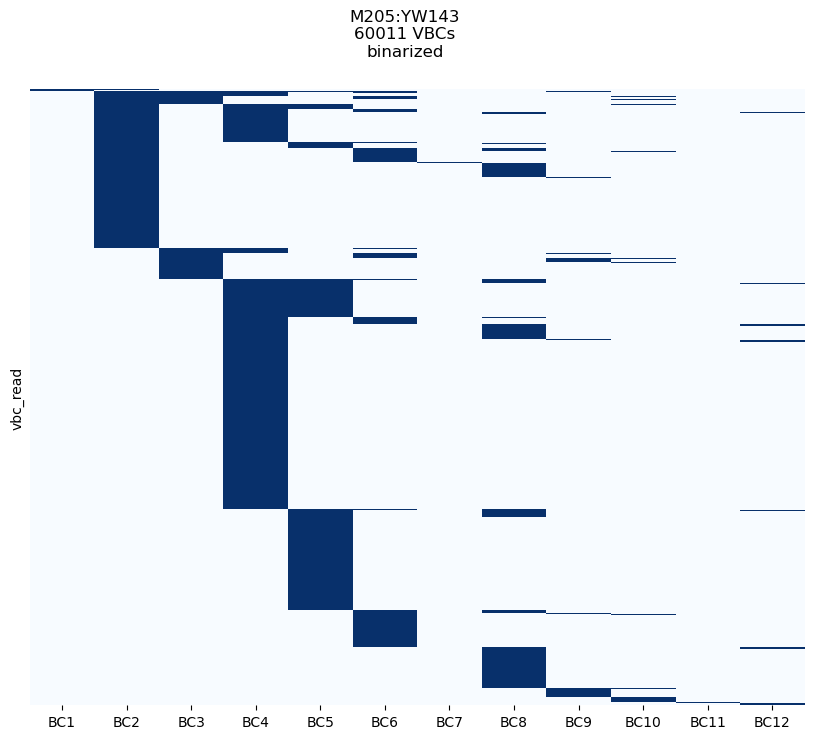

In [46]:
infile = f'{outdir}/YW143.nbcm.tsv'
nbmdf = load_mapseq_df(infile)
nbmdf
g = get_plot_binarized(nbmdf, expid=f'{project_id}:YW143') 

INFO:root:loading /Users/hover/mapseq/M205/YW144.nbcm.tsv format='None' use_dask=False use_arrow=True
INFO:root:fformat is None. Will not apply datatype checks/correction.


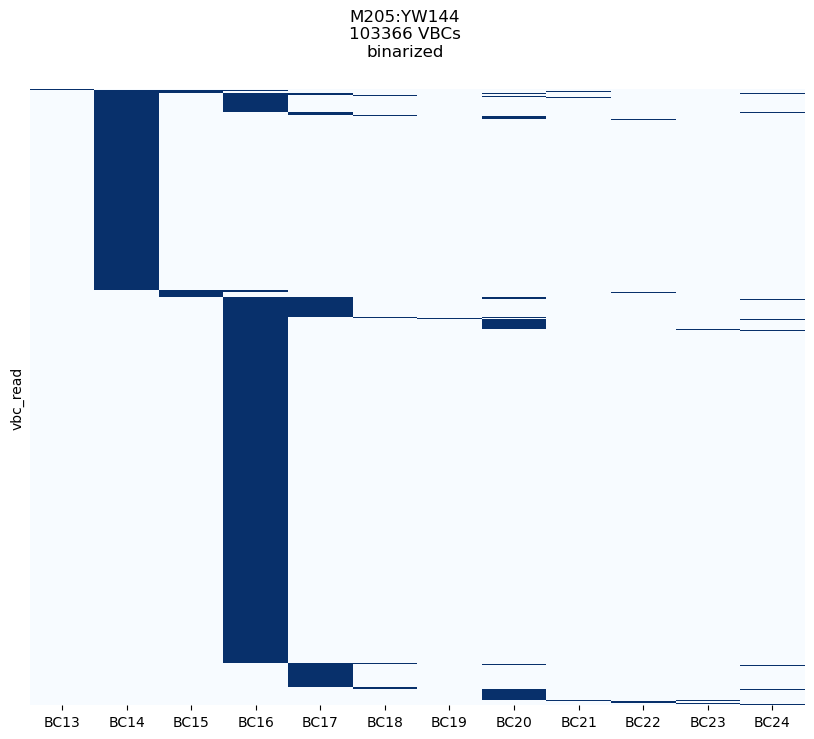

In [48]:
infile = f'{outdir}/YW144.nbcm.tsv'
nbmdf2 = load_mapseq_df(infile)
nbmdf2
g = get_plot_binarized(nbmdf2, expid=f'{project_id}:YW144') 